<a href="https://colab.research.google.com/github/ola-sumbo/employee-attrition-aif360/blob/master/Trial_on_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#for data visualization
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import missingno as mssno
seed=45

In [2]:
#for ML
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle

In [5]:
from google.colab import files
uploaded = files.upload()

Saving SampleSubmission.csv to SampleSubmission.csv


In [6]:
train = pd.read_csv('/content/Train (1).csv')
test = pd.read_csv('/content/Test (1).csv')
ssn = pd.read_csv('/content/SampleSubmission.csv')

**[Modeling Begins](https://www.analyticsvidhya.com/blog/2017/08/catboost-automated-categorical-data/)**

In [7]:
!pip install catboost
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor

     |████████████████████████████████| 66.3MB 53kB/s 


In [9]:
#Displaying Files
train.head()

ID Policy Start Date Policy End Date  ...  State  ProductName target
0  0040R73        2010-05-14      2011-05-13  ...    NaN  Car Classic      0
1  0046BNK        2010-11-29      2011-11-28  ...    NaN  Car Classic      1
2  005QMC3        2010-03-21      2011-03-20  ...    NaN  Car Classic      0
3  0079OHW        2010-08-21      2011-08-20  ...    NaN      CarSafe      0
4  00BRP63        2010-08-29      2010-12-31  ...  Lagos        Muuve      1

[5 rows x 14 columns]

In [10]:
#Data Types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [8]:
# Code to get number of categories in missing value columns
print("Number of Categories in: ")
for ColName in train[['State','Gender','Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make','LGA_Name','target']]:
  print("{} = {}".format(ColName, len(train[ColName].unique())))

Number of Categories in: 
State = 112
Gender = 8
Car_Category = 17
Subject_Car_Colour = 46
Subject_Car_Make = 75
LGA_Name = 259
target = 2


**Missing data**

In [9]:
#Frequent Categorical Imputation another method for class purposes 
#1. Function to replace NAN values with mode value
def impute_nan_most_frequent_category(train,ColName):
    # .mode()[0] - gives first category name
    most_frequent_category=train[ColName].mode()[0]
# replace nan values with most occured category
    train[ColName + "_Imputed"] = train[ColName]
    train[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)

In [10]:
#2. Call function to impute most occured category
for Columns in ['State','Gender','Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make','LGA_Name']:
  impute_nan_most_frequent_category(train,Columns)
    
#Display imputed result
train[['State','State_Imputed','Gender','Gender_Imputed','Car_Category',
       'Car_Category_Imputed', 'Subject_Car_Colour','Subject_Car_Colour_Imputed', 'Subject_Car_Make_Imputed','Subject_Car_Make_Imputed','LGA_Name','LGA_Name_Imputed']].head(10)

#3. Drop actual columns
train = train.drop(['State','Gender','Car_Category', 'Subject_Car_Colour','Subject_Car_Make','LGA_Name'], axis = 1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


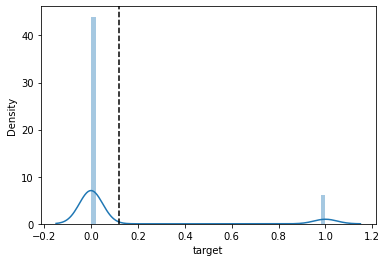

In [11]:
# Distribution of targets and mean 
sns.distplot(train['target'])
plt.axvline(train['target'].mean(), color="k", linestyle="--")

**Dealing with Missing Values in the test set**

In [12]:
#Frequent Categorical Imputation another method for class purposes 
#1. Function to replace NAN values with mode value
def impute_nan_most_frequent_category(test,ColName):
    # .mode()[0] - gives first category name
    most_frequent_category=test[ColName].mode()[0]
# replace nan values with most occured category
    test[ColName + "_Imputed"] = test[ColName]
    test[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)

In [13]:
#2. Call function to impute most occured category
for Columns in ['State','Gender','Car_Category', 'Subject_Car_Colour', 'Subject_Car_Make','LGA_Name']:
  impute_nan_most_frequent_category(test,Columns)
    
#Display imputed result
test[['State','State_Imputed','Gender','Gender_Imputed','Car_Category','Car_Category_Imputed', 'Subject_Car_Colour','Subject_Car_Colour_Imputed', 'Subject_Car_Make_Imputed','Subject_Car_Make_Imputed','LGA_Name','LGA_Name_Imputed']].head(10)

#3. Drop actual columns
test = test.drop(['State','Gender','Car_Category', 'Subject_Car_Colour','Subject_Car_Make','LGA_Name'], axis = 1)

**Basic Preprocessing**

In [14]:
train_1 = train.copy()
#train_1.drop(labels = 'target', axis = 1, inplace = True)
train_1['Status'] = 'Train Set' # adding a column Status to differentiate between Train and Test in the combined set
test_1 = test.copy()
test_1['Status'] = 'Test Set'

In [15]:
date_col = ['Policy Start Date','Policy End Date','First Transaction Date']
num_col = ['Age', 'No_Pol']
id_col = ['ID']
cat_col = [col for col in train.columns if col not in date_col+num_col+id_col]
cat_col

['ProductName',
 'target',
 'State_Imputed',
 'Gender_Imputed',
 'Car_Category_Imputed',
 'Subject_Car_Colour_Imputed',
 'Subject_Car_Make_Imputed',
 'LGA_Name_Imputed']

In [16]:
#and for the train set
train_1['Newtransact Y/N'] = np.where(train_1['Policy Start Date'] ==train_1['First Transaction Date'], 'No', 'Yes')
# Now we subtract
train_1['Age of policy'] = pd.to_datetime(train_1['Policy End Date']) - pd.to_datetime(train_1['Policy Start Date'])
train_1['Age of policy'] = train_1['Age of policy'].dt.days.astype(float) + (train_1['Age of policy'].dt.seconds.astype(float) / 86400)
train_1['Newtransact Y/N'] = train_1['Newtransact Y/N'].astype('category')

In [19]:
# Remove variables that were used to create new features
cols_2_remove = ['Policy Start Date','Policy End Date', 'First Transaction Date']
train_rem = train.copy()
train_rem.drop(cols_2_remove, axis = 1, inplace = True)
train_1.drop(cols_2_remove, axis=1, inplace=True)
train_1 = train_1.drop('ID', axis=1)

In [20]:
#and for the test set
test_1['Newtransact Y/N'] = np.where(test['Policy Start Date'] ==test_1['First Transaction Date'], 'No', 'Yes')
# Now we subtract
test_1['Age of policy'] = pd.to_datetime(test_1['Policy End Date']) - pd.to_datetime(test_1['Policy Start Date'])
test_1['Age of policy'] = test_1['Age of policy'].dt.days.astype(float) + (test_1['Age of policy'].dt.seconds.astype(float) / 86400)
test_1['Newtransact Y/N'] = test_1['Newtransact Y/N'].astype('category')

In [21]:
# Remove variables that were used to create new features
cols_2_remove = ['Policy Start Date','Policy End Date', 'First Transaction Date']
test_rem = train.copy()
test_rem.drop(cols_2_remove, axis = 1, inplace = True)
test_1.drop(cols_2_remove, axis=1, inplace=True)
test_1 = test_1.drop('ID', axis=1)

## $$1.\ Data\ Preparation$$
### 1.1 CatBoost installation
If you have not already installed CatBoost, you can do so by running '!pip install catboost' command.  
  
Also you should install ipywidgets package and run special command before launching jupyter notebook to draw plots.

In [22]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [24]:
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [163]:
X = train_1.drop('target', axis=1)
y = train_1.target

In [164]:
print(X.dtypes)
categorical_features_indices = np.where(X.dtypes != np.float)[0]

Age                              int64
No_Pol                           int64
ProductName                     object
State_Imputed                   object
Gender_Imputed                  object
Car_Category_Imputed            object
Subject_Car_Colour_Imputed      object
Subject_Car_Make_Imputed        object
LGA_Name_Imputed                object
Status                          object
Newtransact Y/N               category
Age of policy                  float64
dtype: object


**Data Splitting**

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_1

##$$2.\ CatBoost\ Basics$$ 

In [153]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [166]:
#Gender processing
train_1.Gender_Imputed.unique()
mapper = {"Male":"M","Female":'F','Entity':'O','Joint Gender':'O','Unknown':'O','NO GENDER':'O','NOT STATED':'O','SEX':'O'}

In [167]:
train_1.Gender = train_1.Gender_Imputed.map(mapper)
test_1.Gender = test_1.Gender_Imputed.map(mapper)

### 2.1 Model Training
Now let's create the model itself: We would go here with default parameters (as they provide a _really_ good baseline almost all the time), the only thing We would like to specify here is `custom_loss` parameter, as this would give us an ability to see what's going on in terms of this competition metric - accuracy, as well as to be able to watch for logloss, as it would be more smooth on dataset of such size.

In [156]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [168]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**As you can see, it is possible to watch our model learn through verbose output or with nice plots (personally I would definately go with the second option - just check out those plots: you can, for example, zoom in areas of interest!)

With this we can see that the best accuracy value of 0.8816646429 (on validation set) was acheived on 999 boosting step.
**

### 2.2 Model Cross-Validation

It is good to validate your model, but to cross-validate it - even better. And also with plots! So with no more words:

In [169]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Now we have values of our loss functions at each boosting step averaged by 3 folds, which should provide us with a more accurate estimation of our model performance:**

In [170]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.89±0.00 on step 152


In [171]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8860834342521479


## As we can see, our initial estimation of performance on single validation fold was less optimistic - that is why cross-validation is so important!

### 2.3 Model Applying
All you have to do to get predictions is

In [172]:
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)
print(predictions[:10])
print(predictions_probs[:10])

[0 1 0 0 1 0 0 0 0 0]
[[6.48909258e-01 3.51090742e-01]
 [2.69662241e-01 7.30337759e-01]
 [8.88235067e-01 1.11764933e-01]
 [8.86280954e-01 1.13719046e-01]
 [2.42825585e-01 7.57174415e-01]
 [9.12456880e-01 8.75431203e-02]
 [9.99059896e-01 9.40103580e-04]
 [8.33504308e-01 1.66495692e-01]
 [8.62996289e-01 1.37003711e-01]
 [9.92461259e-01 7.53874061e-03]]


**save one**

In [46]:
import pandas as pd
submisstion = pd.DataFrame()
test['ID'] = ssn['ID'] 
ssn['target'] = model.predict(X_test)

In [50]:
ssn.to_csv('crossvalidone.csv', index=False)

**Data Segmentation**

In [96]:
desired_apriori=0.10

# Get the indices per target value
idx_0 = train_desired_apriori=0.10

# Get the indices per target value
idx_0 = train_1[train_1.target == 0].index
idx_1 = train_1[train_1.target == 1].index

# Get original number of records per target value
nb_0 = len(train_1.loc[idx_0])
nb_1 = len(train_1.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_1 = int(undersampling_rate*nb_1)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_1))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_1)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

Rate to undersample records with target=0: 1.232586596385542
Number of records with target=0 after undersampling: 1793


In [51]:
for i in X.select_dtypes(include='category').columns.to_list():
    X[i] = X[i].astype('object')

In [99]:
categorical_features_indices = np.where(X.dtypes == np.object)[0]
categorical_feat = ['ProductName','State_Imputed','Gender_Imputed','Car_Category_Imputed','Subject_Car_Colour_Imputed','Subject_Car_Make_Imputed',       
'LGA_Name_Imputed','Newtransact Y/N']

## $$3.\ CatBoost\ Features$$
You may have noticed that on model creation step I've specified not only `custom_loss` but also `random_seed` parameter. That was done in order to make this notebook reproducible - by default catboost chooses some random value for seed:

In [52]:
model_without_seed = CatBoostClassifier(iterations=10, logging_level='Silent')
model_without_seed.fit(X, y, cat_features=categorical_features_indices)

print('Random seed assigned for this model: {}'.format(model_without_seed.random_seed_))

Random seed assigned for this model: 0


$Let's define some params and create Pool for more convenience. It stores all information about dataset (features, labeles, categorical features indices, weights and and much more).$##

In [54]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

### 3.1 Using the best model
If you essentially have a validation set, it's always better to use the `use_best_model` parameter during training. By default, this parameter is enabled. If it is enabled, the resulting trees ensemble is shrinking to the best iteration.

In [55]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, best_model.predict(X_validation))
))

Simple model validation accuracy: 0.8815

Best model validation accuracy: 0.8818


### 3.2 Early Stopping
If you essentially have a validation set, it's always easier and better to use early stopping. This feature is similar to the previous one, but only in addition to improving the quality it still saves time.

In [56]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 20 s, sys: 1.23 s, total: 21.3 s
Wall time: 11.7 s


In [57]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 3.66 s, sys: 246 ms, total: 3.9 s
Wall time: 2.2 s


In [58]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')

print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Simple model tree count: 500
Simple model validation accuracy: 0.8815

Early-stopped model tree count: 102
Early-stopped model validation accuracy: 0.8805


So we get better quality in a shorter time.

Though as was shown earlier simple validation scheme does not precisely describes model out-of-train score (may be biased because of dataset split) it is still nice to track model improvement dynamics - and thereby as we can see from this example it is really good to stop boosting process earlier (before the overfitting kicks in)

### 3.3 Using Baseline
It is posible to use pre-training results (baseline) for training.

In [59]:
current_params = params.copy()
current_params.update({
    'iterations': 10
})
model = CatBoostClassifier(**current_params).fit(X_train, y_train, categorical_features_indices)
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
# Fit new model
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline);

### 3.4 Snapshot Support
Catboost supports snapshots. You can use it for recovering training after an interruption or for starting training with previous results. 

In [60]:
params_with_snapshot = params.copy()
params_with_snapshot.update({
    'iterations': 5,
    'learning_rate': 0.5,
    'logging_level': 'Verbose'
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)
params_with_snapshot.update({
    'iterations': 10,
    'learning_rate': 0.1,
})
model = CatBoostClassifier(**params_with_snapshot).fit(train_pool, eval_set=validate_pool, save_snapshot=True)

0:	learn: 0.8810023	test: 0.8751656	best: 0.8751656 (0)	total: 8.14ms	remaining: 32.5ms
1:	learn: 0.8825477	test: 0.8754967	best: 0.8754967 (1)	total: 18.5ms	remaining: 27.7ms
2:	learn: 0.8832101	test: 0.8764901	best: 0.8764901 (2)	total: 27.1ms	remaining: 18.1ms
3:	learn: 0.8842036	test: 0.8774834	best: 0.8774834 (3)	total: 36.1ms	remaining: 9.02ms
4:	learn: 0.8842036	test: 0.8774834	best: 0.8774834 (3)	total: 40.9ms	remaining: 0us

bestTest = 0.8774834437
bestIteration = 3

5:	learn: 0.8842036	test: 0.8774834	best: 0.8774834 (3)	total: 49.3ms	remaining: 33.6ms
6:	learn: 0.8840932	test: 0.8778146	best: 0.8778146 (6)	total: 58.2ms	remaining: 26ms
7:	learn: 0.8840932	test: 0.8778146	best: 0.8778146 (6)	total: 66.5ms	remaining: 17.1ms
8:	learn: 0.8840932	test: 0.8778146	best: 0.8778146 (6)	total: 75.3ms	remaining: 8.61ms
9:	learn: 0.8842036	test: 0.8778146	best: 0.8778146 (6)	total: 83ms	remaining: 0us

bestTest = 0.8778145695
bestIteration = 6



### 3.5 User Defined Objective Function
It is possible to create your own objective function. Let's create logloss objective function.

In [61]:
class LoglossObjective(object):
    def calc_ders_range(self, approxes, targets, weights):
        # approxes, targets, weights are indexed containers of floats
        # (containers which have only __len__ and __getitem__ defined).
        # weights parameter can be None.
        #
        # To understand what these parameters mean, assume that there is
        # a subset of your dataset that is currently being processed.
        # approxes contains current predictions for this subset,
        # targets contains target values you provided with the dataset.
        #
        # This function should return a list of pairs (der1, der2), where
        # der1 is the first derivative of the loss function with respect
        # to the predicted value, and der2 is the second derivative.
        #
        # In our case, logloss is defined by the following formula:
        # target * log(sigmoid(approx)) + (1 - target) * (1 - sigmoid(approx))
        # where sigmoid(x) = 1 / (1 + e^(-x)).
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            e = np.exp(approxes[index])
            p = e / (1 + e)
            der1 = (1 - p) if targets[index] > 0.0 else -p
            der2 = -p * (1 - p)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [62]:
model = CatBoostClassifier(
    iterations=10,
    random_seed=42, 
    loss_function=LoglossObjective(), 
    eval_metric="Logloss"
)
# Fit model
model.fit(train_pool)
# Only prediction_type='RawFormulaVal' is allowed with custom `loss_function`
preds_raw = model.predict(X_test, prediction_type='RawFormulaVal')

0:	learn: 0.6753901	total: 118ms	remaining: 1.06s
1:	learn: 0.6583967	total: 242ms	remaining: 966ms
2:	learn: 0.6424630	total: 374ms	remaining: 872ms
3:	learn: 0.6273388	total: 490ms	remaining: 735ms
4:	learn: 0.6129759	total: 603ms	remaining: 603ms
5:	learn: 0.5994149	total: 737ms	remaining: 491ms
6:	learn: 0.5867199	total: 855ms	remaining: 366ms
7:	learn: 0.5747627	total: 969ms	remaining: 242ms
8:	learn: 0.5631970	total: 1.08s	remaining: 121ms
9:	learn: 0.5524275	total: 1.2s	remaining: 0us


**submission two**

In [63]:
import pandas as pd
submisstion = pd.DataFrame()
test['ID'] = ssn['ID'] 
ssn['target'] = preds_raw

In [64]:
ssn.to_csv('submission_two', index=False)

**Save prediction**

### 3.7 Staged Predict
CatBoost model has `staged_predict` method. It allows you to iteratively get predictions for a given range of trees.

In [65]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.39877266 0.47661851 0.39877266 0.31814312 0.39877266]
First class probabilities using the first 5 trees: [0.38184137 0.5141727  0.38184137 0.20381075 0.34301554]
First class probabilities using the first 7 trees: [0.34842461 0.47813261 0.42463219 0.2046893  0.34423472]


### 3.8 Feature Importances
Sometimes it is very important to understand which feature made the greatest contribution to the final result. To do this, the CatBoost model has a `get_feature_importance` method.

In [66]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

ProductName: 54.20384751620841
Subject_Car_Colour_Imputed: 11.949812273960966
Age: 11.0814928848256
No_Pol: 7.6295242323925105
LGA_Name_Imputed: 4.443650049986745
Age of policy: 2.810430053230394
Gender_Imputed: 2.3754603705051305
Car_Category_Imputed: 2.3550005806271335
Subject_Car_Make_Imputed: 1.878856190768003
State_Imputed: 1.2719258474951136
Status: 0.0
Newtransact Y/N: 0.0


This shows that features **`ProductName`** and **`Subject_Car_Colour_Imputed`** had the biggest influence on the result.

3.9 Eval Metrics

The CatBoost has a eval_metrics method that allows to calculate a given metrics on a given dataset. And to draw them of course:)

In [67]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
eval_metrics = model.eval_metrics(validate_pool, ['AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
print(eval_metrics['AUC'][:6])

[0.6820704508480938, 0.6918395120085988, 0.7079673949805854, 0.7029669483777277, 0.7461434086938021, 0.7471068665440266]


### 3.10 Learning Processes Comparison
You can also compare different models learning process on a single plot.

In [69]:
model1 = CatBoostClassifier(iterations=10, depth=1, train_dir='model_depth_1/', logging_level='Silent')
model1.fit(train_pool, eval_set=validate_pool)
model2 = CatBoostClassifier(iterations=10, depth=5, train_dir='model_depth_5/', logging_level='Silent')
model2.fit(train_pool, eval_set=validate_pool);

In [70]:
from catboost import MetricVisualizer
widget = MetricVisualizer(['model_depth_1', 'model_depth_5'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### 3.11 Model Saving
It is always really handy to be able to dump your model to disk (especially if training took some time).

In [71]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

# $$4.\ Parameters\ Tuning$$
While you could always select optimal number of iterations (boosting steps) by cross-validation and learning curve plots, it is also important to play with some of model parameters, and we would like to pay some special attention to `l2_leaf_reg` and `learning_rate`.

In this section, we'll select these parameters using the **`hyperopt`** package.

In [72]:
!pip install hyperopt

In [73]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=500,
        eval_metric='Accuracy',
        random_seed=42,
        verbose=False,
        loss_function='Logloss',
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [74]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 50/50 [55:48<00:00, 66.97s/it, best loss: 0.11375103709836087]
{'l2_leaf_reg': 6.0, 'learning_rate': 0.030601842764723663}


Now let's get all cv data with best parameters:

In [78]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=500,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=False,
    loss_function='Logloss',
)
cv_data = cv(Pool(X, y, cat_features=categorical_features_indices), model.get_params())

In [79]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.8862489629016391


**Prediction and savings**

In [83]:
model.fit(X, y, cat_features=categorical_features_indices)

In [173]:
import pandas as pd
submisstion = pd.DataFrame()
test['ID'] = ssn['ID'] 
ssn['target'] = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


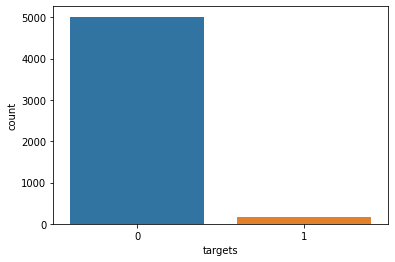

In [174]:
sns.countplot(ssn.targets)

In [91]:
ssn.head()
ssn.drop('targets', axis=1)

ID  target
0     009D84L       1
1     01DO2EQ       1
2     01QM0NU       0
3     024NJLZ       0
4     02BYET3       1
...       ...     ...
5172  ZYXX5AF       0
5173  ZYYOZ5L       0
5174  ZZ1GTKD       0
5175  ZZDXQSI       0
5176  ZZYTLV1       0

[5177 rows x 2 columns]

In [95]:
ssn.to_csv('base_sim_pred_file.csv',index=False)